# Class Challenge: Image Classification of COVID-19 X-rays
# Task 2 [Total points: 30]

## Setup

* This assignment involves the following packages: 'matplotlib', 'numpy', and 'sklearn'. 

* If you are using conda, use the following commands to install the above packages:<br>
```shell
conda install matplotlib
conda install numpy
conda install -c anaconda scikit-learn
```

* If you are using pip, use use the following commands to install the above packages: <br> 
```shell
pip install matplotlib
pip install numpy
pip install sklearn
```

## Data

Please download the data using the following link: [COVID-19](https://drive.google.com/file/d/1Y88tgqpQ1Pjko_7rntcPowOJs_QNOrJ-/view). 

* After downloading 'Covid_Data_GradientCrescent.zip', unzip the file and you should see the following data structure:


|--all<br>
|--------train<br>
|--------test<br>
|--two<br>
|--------train<br>
|--------test<br>


* Put the 'all' folder, the 'two' folder and this python notebook in the **same directory** so that the following code can correctly locate the data.  



## [20 points] Multi-class Classification

In [1]:
import os

import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense , Dropout , GlobalAveragePooling2D
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

os.environ['OMP_NUM_THREADS'] = '-1'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
tf.__version__

'2.1.0'

#### Load Image Data

In [2]:
DATA_LIST = os.listdir('C:/Users/Tiam/Desktop/Class Challenge/Covid_Data_GradientCrescent')
DATASET_PATH  = 'C:/Users/Tiam/Desktop//Class Challenge/Covid_Data_GradientCrescent/all/train'
TEST_DIR =  'C:/Users/Tiam/Desktop/Class Challenge/Covid_Data_GradientCrescent/all/test'
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = len(DATA_LIST)
BATCH_SIZE    = 10  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 75
LEARNING_RATE = 0.0001 # start off with high rate first 0.001 and experiment with reducing it gradually 

#### Generate Training and Validation Batches

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=50,featurewise_center = True,
                                   featurewise_std_normalization = True,width_shift_range=0.2,
                                   height_shift_range=0.2,shear_range=0.25,zoom_range=0.1,
                                   zca_whitening = True,channel_shift_range = 20,
                                   horizontal_flip = True,vertical_flip = True,
                                   validation_split = 0.2,fill_mode='constant')


train_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "training",seed=42,
                                                  class_mode="categorical")

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "validation",
                                                  seed=42,class_mode="categorical")

C:\Users\Tiam\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:341: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


Found 216 images belonging to 4 classes.
Found 54 images belonging to 4 classes.


#### [10 points] Build Model
Hint: Starting from a pre-trained model typically helps performance on a new task, e.g. starting with weights obtained by training on ImageNet. 

In [4]:
# here we are going to make our model that uses VGG16 plus additional models
vgg19 = tf.keras.applications.VGG19(input_shape=(224,224,3),include_top=False,weights='imagenet')
vgg19.trainable = False 

model = Sequential()
model.add(vgg19)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(.2))
model.add(Dense(256,activation='relu'))
model.add(Dropout(.2))
model.add(Dense(128,activation='relu'))
model.add(Dropout(.2))
model.add(Dense(64,activation='relu'))
model.add(Dense(4))


model.summary()        

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               3

#### Build Second Model 

In [16]:
densenet = tf.keras.applications.DenseNet121(input_shape=(224,224,3),include_top=False,weights='imagenet')

model2 = Sequential()
model2.add(densenet)
model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(.25))
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(.25))
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(.25))
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(.25))
model2.add(Dense(128,activation='relu'))
model2.add(Dropout(.25))
model2.add(Dense(64,activation='relu'))
model2.add(Dropout(.25))
model2.add(Dense(64,activation='relu'))
model2.add(Dense(4))


model2.summary()        

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
flatten_2 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               12845312  
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)              

#### [5 points] Train Model

In [17]:
#FIT MODEL
print(len(train_batches))
print(len(valid_batches))

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

adam = Adam(LEARNING_RATE)

model.compile(optimizer=adam,
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

history = model.fit(train_batches,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_batches,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=NUM_EPOCHS)

22
6


C:\Users\Tiam\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Tiam\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 21 steps, validate for 5 steps
Epoch 1/75


C:\Users\Tiam\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Tiam\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


21/21 [==============================] - 39s 2s/step - loss: 0.7059 - accuracy: 0.6990 - val_loss: 0.6500 - val_accuracy: 0.6400
Epoch 2/75
21/21 [==============================] - 37s 2s/step - loss: 0.6910 - accuracy: 0.6699 - val_loss: 0.6231 - val_accuracy: 0.6600
Epoch 3/75
21/21 [==============================] - 38s 2s/step - loss: 0.6331 - accuracy: 0.7524 - val_loss: 0.5199 - val_accuracy: 0.7200
Epoch 4/75
21/21 [==============================] - 37s 2s/step - loss: 0.6714 - accuracy: 0.6990 - val_loss: 0.5532 - val_accuracy: 0.6600
Epoch 5/75
21/21 [==============================] - 37s 2s/step - loss: 0.7308 - accuracy: 0.6845 - val_loss: 0.5253 - val_accuracy: 0.7400
Epoch 6/75
21/21 [==============================] - 37s 2s/step - loss: 0.6144 - accuracy: 0.7379 - val_loss: 0.6007 - val_accuracy: 0.7000
Epoch 7/75
21/21 [==============================] - 37s 2s/step - loss: 0.7188 - accuracy: 0.6602 - val_loss: 0.7652 - val_accuracy: 0.6200
Epoch 8/75
21/21 [=============

#### Train Second Model 

In [7]:
STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

adam = Adam(LEARNING_RATE)

model2.compile(optimizer=adam,
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

history2 = model2.fit(train_batches,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_batches,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=NUM_EPOCHS)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 21 steps, validate for 5 steps
Epoch 1/75


C:\Users\Tiam\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Tiam\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


21/21 [==============================] - 473s 23s/step - loss: 1.7955 - accuracy: 0.2476 - val_loss: 1.4177 - val_accuracy: 0.2600
Epoch 2/75
21/21 [==============================] - 98s 5s/step - loss: 1.7831 - accuracy: 0.2476 - val_loss: 1.3950 - val_accuracy: 0.2800
Epoch 3/75
21/21 [==============================] - 97s 5s/step - loss: 1.6067 - accuracy: 0.2476 - val_loss: 1.3939 - val_accuracy: 0.3000
Epoch 4/75
21/21 [==============================] - 97s 5s/step - loss: 1.5238 - accuracy: 0.2573 - val_loss: 1.3675 - val_accuracy: 0.4000
Epoch 5/75
21/21 [==============================] - 97s 5s/step - loss: 1.4989 - accuracy: 0.2621 - val_loss: 1.3345 - val_accuracy: 0.4800
Epoch 6/75
21/21 [==============================] - 98s 5s/step - loss: 1.3950 - accuracy: 0.3447 - val_loss: 1.3784 - val_accuracy: 0.2400
Epoch 7/75
21/21 [==============================] - 97s 5s/step - loss: 1.4200 - accuracy: 0.2864 - val_loss: 1.3764 - val_accuracy: 0.3000
Epoch 8/75
21/21 [===========

21/21 [==============================] - 107s 5s/step - loss: 0.4867 - accuracy: 0.7816 - val_loss: 0.7082 - val_accuracy: 0.7000
Epoch 60/75
21/21 [==============================] - 104s 5s/step - loss: 0.5670 - accuracy: 0.7087 - val_loss: 0.4842 - val_accuracy: 0.6800
Epoch 61/75
21/21 [==============================] - 107s 5s/step - loss: 0.4845 - accuracy: 0.7282 - val_loss: 0.5114 - val_accuracy: 0.7400
Epoch 62/75
21/21 [==============================] - 102s 5s/step - loss: 0.4318 - accuracy: 0.7718 - val_loss: 0.4762 - val_accuracy: 0.7400
Epoch 63/75
21/21 [==============================] - 99s 5s/step - loss: 0.4877 - accuracy: 0.7524 - val_loss: 0.6413 - val_accuracy: 0.7000
Epoch 64/75
21/21 [==============================] - 97s 5s/step - loss: 0.4440 - accuracy: 0.7767 - val_loss: 0.4385 - val_accuracy: 0.8000
Epoch 65/75
21/21 [==============================] - 97s 5s/step - loss: 0.6287 - accuracy: 0.7330 - val_loss: 0.7448 - val_accuracy: 0.7200
Epoch 66/75
21/21 [==

#### [5 points] Plot Accuracy and Loss During Training

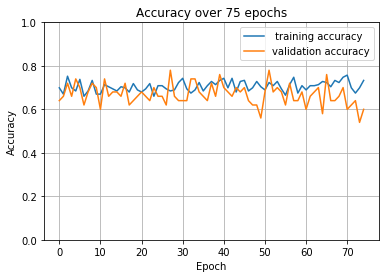

In [25]:
import matplotlib.pyplot as plt


plt.plot(history.history['accuracy'], label=' training accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.title("Accuracy over 75 epochs")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='upper right')
plt.grid(True)

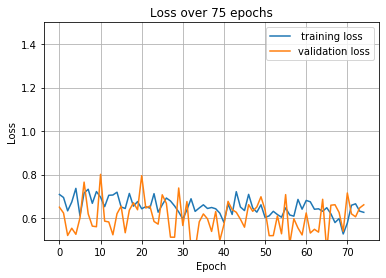

In [30]:
plt.plot(history.history['loss'], label=' training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.title("Loss over 75 epochs")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.5, 1.5])
plt.legend(loc='upper right')
plt.grid(True)

#### Plot Accuracy and Loss During Training of Second Model

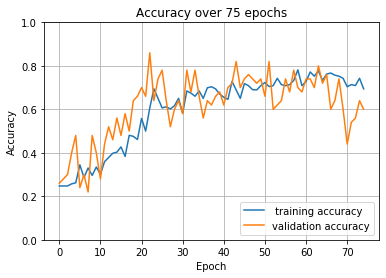

In [27]:
plt.plot(history2.history['accuracy'], label=' training accuracy')
plt.plot(history2.history['val_accuracy'], label = 'validation accuracy')
plt.title("Accuracy over 75 epochs")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.grid(True)

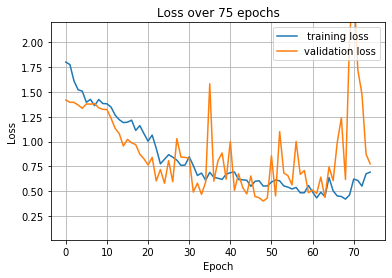

In [29]:
plt.plot(history2.history['loss'], label=' training loss')
plt.plot(history2.history['val_loss'], label = 'validation loss')
plt.title("Loss over 75 epochs")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.01, 2.2])
plt.legend(loc='upper right')
plt.grid(True)

#### Testing Model

In [19]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

eval_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=True,seed=42,class_mode="categorical")
eval_generator.reset()
print(len(eval_generator))
x = model.evaluate_generator(eval_generator,steps = np.ceil(len(eval_generator)),
                           use_multiprocessing = False,verbose = 1,workers=1)
print('Test loss:' , x[0])
print('Test accuracy:',x[1])

Found 36 images belonging to 4 classes.
36
  ...
    to  
  ['...']
36/36 [==============================] - 6s 161ms/step - loss: 0.8754 - accuracy: 0.6667
Test loss: 0.8754034597271433
Test accuracy: 0.6666667


#### Testing the Second Model

In [13]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

eval_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=True,seed=42,class_mode="categorical")
eval_generator.reset()
print(len(eval_generator))
x_model2 = model2.evaluate_generator(eval_generator,steps = np.ceil(len(eval_generator)),
                           use_multiprocessing = False,verbose = 1,workers=1)
print('Test loss:' , x_model2[0])
print('Test accuracy:',x_model2[1])

Found 36 images belonging to 4 classes.
36
  ...
    to  
  ['...']
36/36 [==============================] - 3s 84ms/step - loss: 0.6729 - accuracy: 0.6667
Test loss: 0.6729478830668099
Test accuracy: 0.6666667


## [10 points] TSNE Plot
t-Distributed Stochastic Neighbor Embedding (t-SNE) is a widely used technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. After training is complete, extract features from a specific deep layer of your choice, use t-SNE to reduce the dimensionality of your extracted features to 2 dimensions and plot the resulting 2D features.

Found 270 images belonging to 4 classes.


Text(0.5, 1.0, 'T-SNE Visualization of Features for 1st Model')

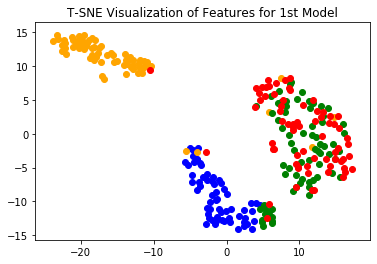

In [31]:
from sklearn.manifold import TSNE

intermediate_layer_model = Model(inputs=model.input,
                                        outputs=model.get_layer('dense_2').output)

tsne_eval_generator = test_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=False,seed=42,class_mode="categorical")

vals = intermediate_layer_model.predict(tsne_eval_generator)

visual = TSNE(n_components=2).fit_transform(vals)

for data,label in zip(visual,tsne_eval_generator.classes):
    if label == 0:
        plt.scatter(data[0],data[1],label=label,color='blue')
    elif label == 1:
        plt.scatter(data[0],data[1],label=label,color='orange')
    
    elif label == 2:
        plt.scatter(data[0],data[1],label=label,color='green')
        
    elif label == 3:
        plt.scatter(data[0],data[1],label=label,color='red')      

plt.title('T-SNE Visualization of Features for 1st Model')

#### TSNE Plot of the DenseNet Model

Found 270 images belonging to 4 classes.


Text(0.5, 1.0, 'T-SNE Visualization of Features for 2nd Model')

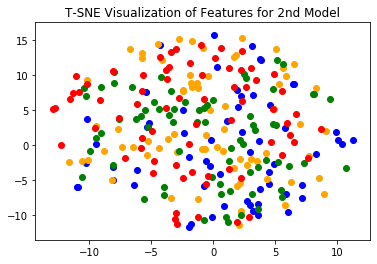

In [32]:
from sklearn.manifold import TSNE

intermediate_layer_model2 = Model(inputs=model2.input,
                                        outputs=model2.get_layer('dense_18').output)

tsne_eval_generator = test_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=False,seed=42,class_mode="categorical")

vals2 = intermediate_layer_model2.predict(tsne_eval_generator)

visual2 = TSNE(n_components=2).fit_transform(vals2)

for data,label in zip(visual2,tsne_eval_generator.classes):
    if label == 0:
        plt.scatter(data[0],data[1],label=label,color='blue')
    elif label == 1:
        plt.scatter(data[0],data[1],label=label,color='orange')
    
    elif label == 2:
        plt.scatter(data[0],data[1],label=label,color='green')
        
    elif label == 3:
        plt.scatter(data[0],data[1],label=label,color='red')   

plt.title('T-SNE Visualization of Features for 2nd Model')

<!-- ## Task 2: COVID-19 vs Normal vs Tertiary Pneumonia (Bacterial and Viral) -->

<!-- #### Renew Training Batch and Validation Batch -->

<!-- #### Renew Model -->